Using device: cuda
Skipping incomplete line 6:  1228 (_missing descriptor)

Skipping incomplete line 10:  1232 (_missing descriptor)

Skipping incomplete line 586:  1808 (_missing descriptor)

Skipping image 2099 due to low or high overall brightness.
Skipping image 2100 due to low or high overall brightness.
Skipping image 2101 due to low or high overall brightness.
Skipping image 2102 due to low or high overall brightness.
Skipping image 2103 due to low or high overall brightness.
Skipping image 2104 due to low or high overall brightness.
Skipping image 2105 due to low or high overall brightness.
Skipping image 2106 due to low or high overall brightness.
Skipping image 3283 due to low or high overall brightness.
Skipping image 3860 due to low or high overall brightness.
Skipping image 3861 due to low or high overall brightness.
Skipping image 3862 due to low or high overall brightness.
Skipping image 3883 due to low or high overall brightness.
Skipping incomplete line 834:  4056 (_mi

G:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
G:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


              precision    recall  f1-score   support

        male       0.80      0.86      0.83       486
      female       0.74      0.67      0.70       305

    accuracy                           0.78       791
   macro avg       0.77      0.76      0.77       791
weighted avg       0.78      0.78      0.78       791



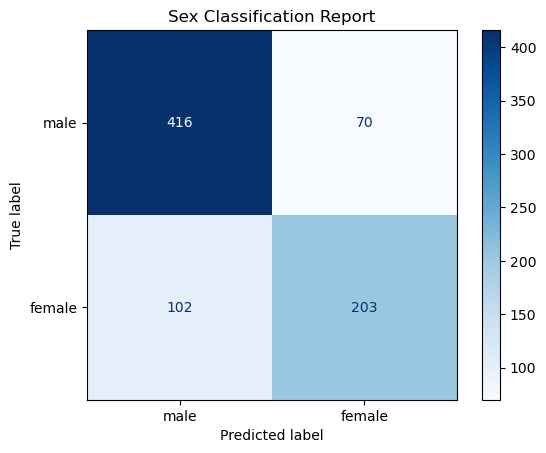

Accuracy of the model on the test images for Sex: 78.26%
male Accuracy: 80.31%
female Accuracy: 74.36%
              precision    recall  f1-score   support

       child       0.43      0.37      0.40        62
        teen       0.45      0.18      0.26        71
       adult       0.86      0.95      0.90       625
      senior       0.65      0.33      0.44        33

    accuracy                           0.81       791
   macro avg       0.60      0.46      0.50       791
weighted avg       0.78      0.81      0.79       791



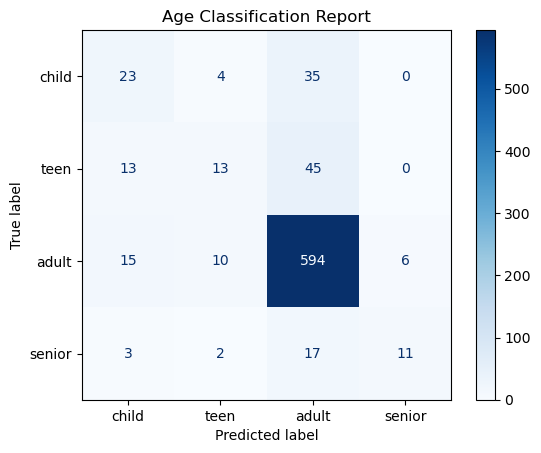

Accuracy of the model on the test images for Age: 81.04%
child Accuracy: 42.59%
teen Accuracy: 44.83%
adult Accuracy: 85.96%
senior Accuracy: 64.71%
              precision    recall  f1-score   support

       white       0.97      0.98      0.98       729
      yellow       0.38      0.23      0.29        13
       black       0.82      0.76      0.79        49

    accuracy                           0.96       791
   macro avg       0.72      0.66      0.68       791
weighted avg       0.95      0.96      0.95       791



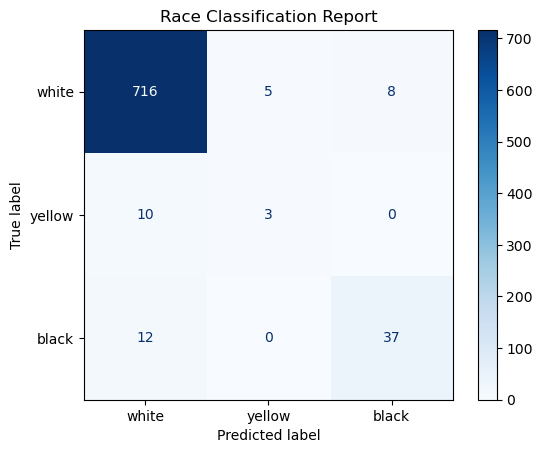

Accuracy of the model on the test images for Race: 95.58%
white Accuracy: 97.02%
yellow Accuracy: 37.50%
black Accuracy: 82.22%
              precision    recall  f1-score   support

     smiling       0.68      0.70      0.69       362
     serious       0.71      0.72      0.71       412
       funny       0.33      0.06      0.10        17

    accuracy                           0.69       791
   macro avg       0.57      0.49      0.50       791
weighted avg       0.69      0.69      0.69       791



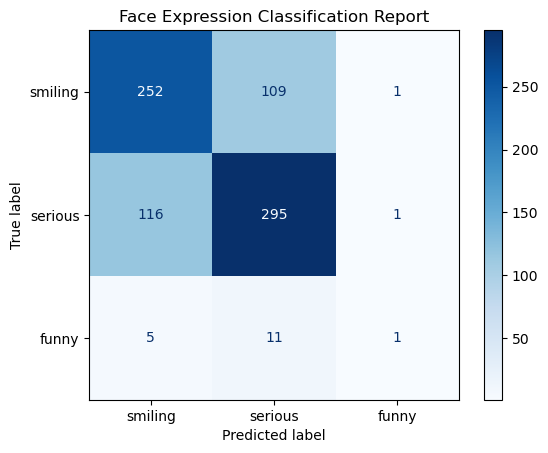

Accuracy of the model on the test images for Face: 69.28%
smiling Accuracy: 67.56%
serious Accuracy: 71.08%
funny Accuracy: 33.33%


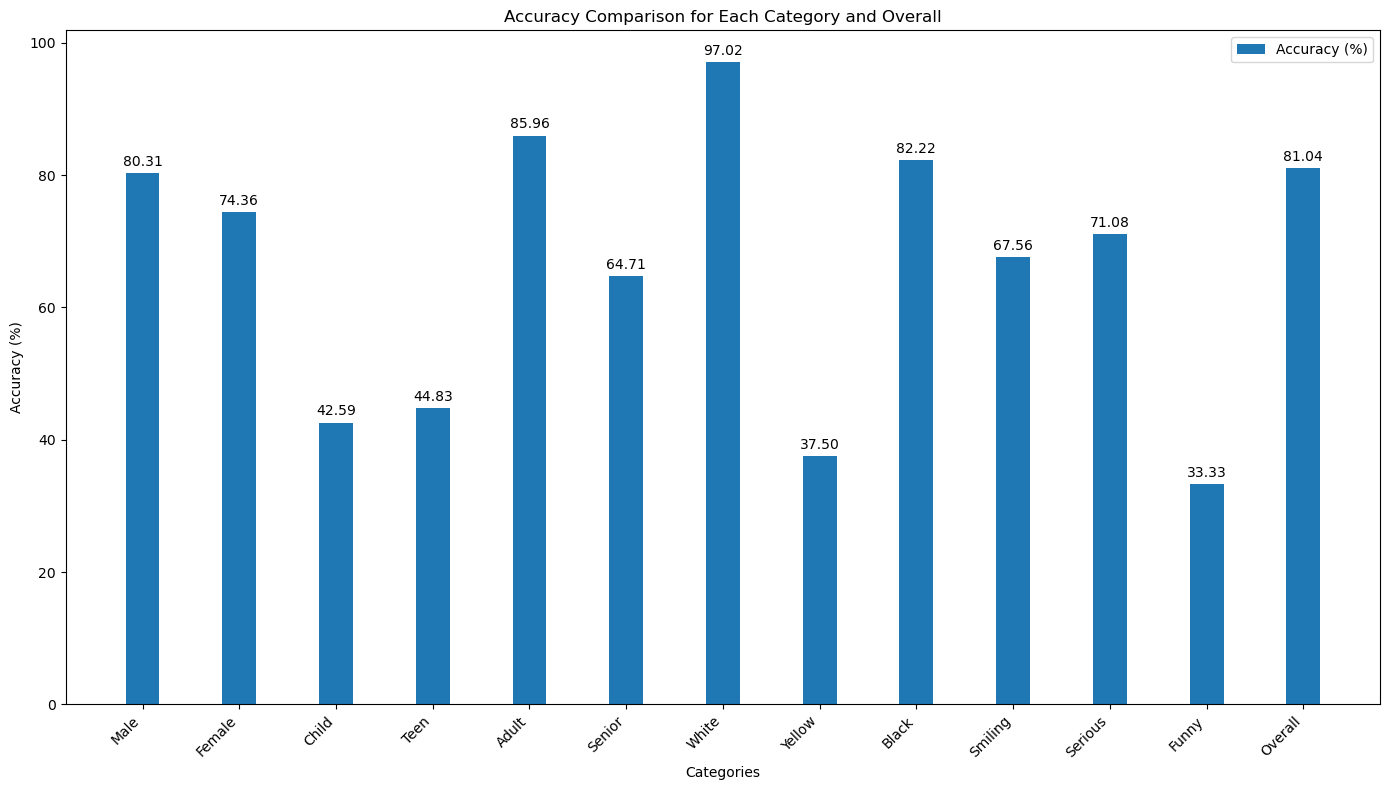

In [10]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 导入 nn 模块
import torch.nn as nn

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 自定义数据集类
class FaceDataset(Dataset):
    def __init__(self, data_files, raw_data_dir, transform=None, brightness_threshold=0.005, center_brightness_threshold=0.96):
        self.data_files = data_files
        self.raw_data_dir = raw_data_dir
        self.transform = transform
        self.brightness_threshold = brightness_threshold
        self.center_brightness_threshold = center_brightness_threshold
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for data_file in self.data_files:
            with open(data_file, 'r') as f:
                for line_number, line in enumerate(f, start=1):
                    parts = line.strip().split()
                    if len(parts) < 5:
                        print(f"Skipping incomplete line {line_number}: {line}")
                        continue  # 跳过不完整或错误的数据行

                    try:
                        image_id = parts[0]
                        sex = parts[2].strip('()')
                        age = parts[4].strip('()')
                        race = parts[6].strip('()')
                        face = parts[8].strip('()')

                        image_path = os.path.join(self.raw_data_dir, image_id)
                        file_size_kb = os.path.getsize(image_path) / 1024

                        if file_size_kb < 20:
                            with open(image_path, 'rb') as f:
                                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (128, 128)))
                        else:
                            with open(image_path, 'rb') as f:
                                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (512, 512)))
                                img = img.resize((128, 128))

                        img_array = np.array(img).astype(float)
                        avg_brightness = np.mean(img_array)
                        if avg_brightness < 255 * self.brightness_threshold or avg_brightness > 255 * (1 - self.brightness_threshold):
                            print(f"Skipping image {image_id} due to low or high overall brightness.")
                            continue  # 跳过过于暗或亮的图片

                        center_region = img_array[48:80, 48:80]  # 中心32x32区域
                        center_avg_brightness = np.mean(center_region)
                        if center_avg_brightness > 255 * self.center_brightness_threshold:
                            print(f"Skipping image {image_id} due to high brightness in the center region.")
                            continue  # 跳过中心区域过亮的图片

                        samples.append((image_id, sex, age, race, face))
                    except IndexError as e:
                        print(f"Skipping malformed line {line_number} due to error: {e}\nLine content: {line}")
                    except FileNotFoundError as e:
                        print(f"Image file not found: {image_path}. Skipping...")
                    except Exception as e:
                        print(f"Failed to process image {image_id}: {e}")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, sex, age, race, face = self.samples[idx]
        image_path = os.path.join(self.raw_data_dir, image_id)

        file_size_kb = os.path.getsize(image_path) / 1024

        if file_size_kb < 20:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (128, 128)))
        else:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (512, 512)))
                img = img.resize((128, 128))
        
        # 确保图像为RGB格式
        img = img.convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        sex_label = {'male': 0, 'female': 1}.get(sex, -1)
        age_label = {'child': 0, 'teen': 1, 'adult': 2, 'senior': 3}.get(age, -1)
        race_label = {'white': 0, 'yellow': 1, 'black': 2, 'hispanic': 0, 'asian': 1, 'other': 0}.get(race, -1)
        face_label = {'smiling': 0, 'serious': 1, 'funny': 2}.get(face, -1)

        labels = [sex_label, age_label, race_label, face_label]
        if any(label == -1 for label in labels):
            print(f"Invalid label in sample: {self.samples[idx]}")
            raise ValueError(f"Invalid label in sample: {self.samples[idx]}")

        return img, torch.tensor(labels, dtype=torch.long)

# 数据变换，包括数据增强
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 加载数据集
dataset = FaceDataset(
    data_files=['G:/PR work/face/faceDR', 'G:/PR work/face/faceDS'],
    raw_data_dir='G:/PR work/face/rawdata',
    transform=train_transform
)

# 打乱数据集并划分训练集和测试集
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1523))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 加载预训练的 ResNet50 模型
resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_ftrs)  # 修改最后一层全连接层，使其输出维度不变
resnet.eval()
resnet.to(device)

# 定义特征提取函数
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = {'sex': [], 'age': [], 'race': [], 'face': []}
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            feat = model(images).cpu().numpy()
            features.extend(feat)
            labels['sex'].extend(lbls[:, 0].cpu().numpy())
            labels['age'].extend(lbls[:, 1].cpu().numpy())
            labels['race'].extend(lbls[:, 2].cpu().numpy())
            labels['face'].extend(lbls[:, 3].cpu().numpy())
    return np.array(features), labels

# 提取特征
try:
    train_features, train_labels = extract_features(resnet, train_loader)
    test_features, test_labels = extract_features(resnet, test_loader)
except Exception as e:
    print(f"Error during feature extraction: {e}")
    exit(1)

# 使用PCA进行降维
pca = PCA(n_components=128)  # 选择合适的主成分数量
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

# 训练 SVM 分类器
svm_sex = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0, probability=True))
svm_age = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0, probability=True))
svm_race = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0, probability=True))
svm_face = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0, probability=True))

try:
    svm_sex.fit(train_features_pca, train_labels['sex'])
    svm_age.fit(train_features_pca, train_labels['age'])
    svm_race.fit(train_features_pca, train_labels['race'])
    svm_face.fit(train_features_pca, train_labels['face'])
except Exception as e:
    print(f"Error during SVM training: {e}")
    exit(1)

# 评估模型
def evaluate_model(svm, X_test, y_test, class_names, title):
    try:
        y_pred = svm.predict(X_test)
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        cm = confusion_matrix(y_test, y_pred, labels=list(range(len(class_names))))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title)
        plt.show()
        
        # 输出整体准确率
        overall_accuracy = accuracy_score(y_test, y_pred) * 100
        print(f"Accuracy of the model on the test images for {title.split()[0]}: {overall_accuracy:.2f}%")
        
        # 输出每个类别的准确率
        report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
        class_accuracies = [report[class_name]['precision'] * 100 for class_name in class_names]
        for i, class_name in enumerate(class_names):
            print(f"{class_name} Accuracy: {class_accuracies[i]:.2f}%")
        
        return overall_accuracy, class_accuracies
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return 0, []
    


# 评估各个分类器并收集结果
accuracies = []

overall_acc_sex, class_accs_sex = evaluate_model(svm_sex, test_features_pca, test_labels['sex'], ['male', 'female'], 'Sex Classification Report')
accuracies.append(('Sex', overall_acc_sex, class_accs_sex))

overall_acc_age, class_accs_age = evaluate_model(svm_age, test_features_pca, test_labels['age'], ['child', 'teen', 'adult', 'senior'], 'Age Classification Report')
accuracies.append(('Age', overall_acc_age, class_accs_age))

overall_acc_race, class_accs_race = evaluate_model(svm_race, test_features_pca, test_labels['race'], ['white', 'yellow', 'black'], 'Race Classification Report')
accuracies.append(('Race', overall_acc_race, class_accs_race))

overall_acc_face, class_accs_face = evaluate_model(svm_face, test_features_pca, test_labels['face'], ['smiling', 'serious', 'funny'], 'Face Expression Classification Report')
accuracies.append(('Face', overall_acc_face, class_accs_face))

# 收集所有类别的准确率和总体准确率
all_class_accuracies = []
all_overall_accuracies = []

for category, overall_acc, class_accs in accuracies:
    all_overall_accuracies.append(overall_acc)
    all_class_accuracies.extend(class_accs)

# 计算总的准确度（所有分类器的整体准确率的平均值）
overall_accuracy_mean = np.mean(all_overall_accuracies)

# 添加总体准确率到列表中
all_overall_accuracies.append(overall_accuracy_mean)
all_class_accuracies.append(overall_accuracy_mean)

# 标签
labels = [
    'Male', 'Female',
    'Child', 'Teen', 'Adult', 'Senior',
    'White', 'Yellow', 'Black',
    'Smiling', 'Serious', 'Funny',
    'Overall'
]

# 绘制总体准确率和每个类别的准确率对比直方图
x = np.arange(len(labels))  # 标签位置
width = 0.35  # 柱状图宽度

fig, ax = plt.subplots(figsize=(14, 8))
rects = ax.bar(x, all_class_accuracies[:len(labels)], width, label='Accuracy (%)')

# 添加数值标签
for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel('Categories')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison for Each Category and Overall')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.show()



